##### Copyright 2020 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BigTransfer (BiT): A step-by-step tutorial for state-of-the-art vision

This colab demonstrates how to:
1. Load BiT models in PyTorch
2. Make predictions using BiT pre-trained on ImageNet
3. Fine-tune BiT on 5-shot CIFAR10 and get amazing results!

It is good to get an understanding or quickly try things. However, to run longer training runs, we recommend using the commandline scripts at http://github.com/google-research/big_transfer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# BiT는 기본적으로 세 가지 데이터 세트에 대하여 ResNet 기반의 모델로 학습을 진행
# 1) Small dataset: ImageNet-1k (약 100만 개)
# 2) Medium dataset: ImageNet 원본 (약 2100만 개)
# 3) Large dataset: 억 단위 이미지 데이터 세트

# Large로 학습한 뒤에 ImageNet-1k로 Fine-tuning하면 거의 88% 얻음
# 참고로 그냥 small dataest으로만 학습하면 80% 정도 성능 얻음

In [100]:
from functools import partial
from collections import OrderedDict

In [101]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import seaborn as sn
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [102]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision as tv
from torch.utils.data import DataLoader
import torch.optim as optim


In [103]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Reading weight data from the Cloud bucket

In [104]:
import requests
import io

In [105]:
def get_weights(bit_variant):
  response = requests.get(f'https://storage.googleapis.com/bit_models/{bit_variant}.npz')
  response.raise_for_status()
  return np.load(io.BytesIO(response.content))

In [106]:
weights = get_weights('BiT-M-R50x1')  # You could use other variants, such as R101x3 or R152x4 here, but it is not advisable in a colab.

# Defining the architecture and loading weights

In [107]:
class StdConv2d(nn.Conv2d):
  def forward(self, x):
    w = self.weight
    v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
    w = (w - m) / torch.sqrt(v + 1e-10)
    return F.conv2d(x, w, self.bias, self.stride, self.padding, self.dilation, self.groups)

In [108]:
def conv3x3(cin, cout, stride=1, groups=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=3, stride=stride, padding=1, bias=bias, groups=groups)

def conv1x1(cin, cout, stride=1, bias=False):
  return StdConv2d(cin, cout, kernel_size=1, stride=stride, padding=0, bias=bias)

In [109]:
def tf2th(conv_weights):
  """Possibly convert HWIO to OIHW"""
  if conv_weights.ndim == 4:
    conv_weights = np.transpose(conv_weights, [3, 2, 0, 1])
  return torch.from_numpy(conv_weights)

In [110]:
class PreActBottleneck(nn.Module):
  """
  Follows the implementation of "Identity Mappings in Deep Residual Networks" here:
  https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua

  Except it puts the stride on 3x3 conv when available.
  """
  def __init__(self, cin, cout=None, cmid=None, stride=1):
    super().__init__()
    cout = cout or cin
    cmid = cmid or cout//4

    self.gn1 = nn.GroupNorm(32, cin)
    self.conv1 = conv1x1(cin, cmid)
    self.gn2 = nn.GroupNorm(32, cmid)
    self.conv2 = conv3x3(cmid, cmid, stride)  # Original ResNetv2 has it on conv1!!
    self.gn3 = nn.GroupNorm(32, cmid)
    self.conv3 = conv1x1(cmid, cout)
    self.relu = nn.ReLU(inplace=True)

    if (stride != 1 or cin != cout):
      # Projection also with pre-activation according to paper.
      self.downsample = conv1x1(cin, cout, stride)

  def forward(self, x):
      # Conv'ed branch
      out = self.relu(self.gn1(x))

      # Residual branch
      residual = x
      if hasattr(self, 'downsample'):
          residual = self.downsample(out)

      # The first block has already applied pre-act before splitting, see Appendix.
      out = self.conv1(out)
      out = self.conv2(self.relu(self.gn2(out)))
      out = self.conv3(self.relu(self.gn3(out)))

      return out + residual

  def load_from(self, weights, prefix=''):
    with torch.no_grad():
      self.conv1.weight.copy_(tf2th(weights[prefix + 'a/standardized_conv2d/kernel']))
      self.conv2.weight.copy_(tf2th(weights[prefix + 'b/standardized_conv2d/kernel']))
      self.conv3.weight.copy_(tf2th(weights[prefix + 'c/standardized_conv2d/kernel']))
      self.gn1.weight.copy_(tf2th(weights[prefix + 'a/group_norm/gamma']))
      self.gn2.weight.copy_(tf2th(weights[prefix + 'b/group_norm/gamma']))
      self.gn3.weight.copy_(tf2th(weights[prefix + 'c/group_norm/gamma']))
      self.gn1.bias.copy_(tf2th(weights[prefix + 'a/group_norm/beta']))
      self.gn2.bias.copy_(tf2th(weights[prefix + 'b/group_norm/beta']))
      self.gn3.bias.copy_(tf2th(weights[prefix + 'c/group_norm/beta']))
      if hasattr(self, 'downsample'):
        self.downsample.weight.copy_(tf2th(weights[prefix + 'a/proj/standardized_conv2d/kernel']))
    return self

In [111]:
class ResNetV2(nn.Module):
  BLOCK_UNITS = {
      'r50': [3, 4, 6, 3],
      'r101': [3, 4, 23, 3],
      'r152': [3, 8, 36, 3],
  }

  def __init__(self, block_units, width_factor, head_size=21843, zero_head=False):
    super().__init__()
    wf = width_factor  # shortcut 'cause we'll use it a lot.

    self.root = nn.Sequential(OrderedDict([
        ('conv', StdConv2d(3, 64*wf, kernel_size=7, stride=2, padding=3, bias=False)),
        ('padp', nn.ConstantPad2d(1, 0)),
        ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0)),
        # The following is subtly not the same!
        #('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))

    self.body = nn.Sequential(OrderedDict([
        ('block1', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin= 64*wf, cout=256*wf, cmid=64*wf))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=256*wf, cout=256*wf, cmid=64*wf)) for i in range(2, block_units[0] + 1)],
        ))),
        ('block2', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=256*wf, cout=512*wf, cmid=128*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=512*wf, cout=512*wf, cmid=128*wf)) for i in range(2, block_units[1] + 1)],
        ))),
        ('block3', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin= 512*wf, cout=1024*wf, cmid=256*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=1024*wf, cout=1024*wf, cmid=256*wf)) for i in range(2, block_units[2] + 1)],
        ))),
        ('block4', nn.Sequential(OrderedDict(
            [('unit01', PreActBottleneck(cin=1024*wf, cout=2048*wf, cmid=512*wf, stride=2))] +
            [(f'unit{i:02d}', PreActBottleneck(cin=2048*wf, cout=2048*wf, cmid=512*wf)) for i in range(2, block_units[3] + 1)],
        ))),
    ]))

    self.zero_head = zero_head
    self.head = nn.Sequential(OrderedDict([
        ('gn', nn.GroupNorm(32, 2048*wf)),
        ('relu', nn.ReLU(inplace=True)),
        ('avg', nn.AdaptiveAvgPool2d(output_size=1)),
        ('conv', nn.Conv2d(2048*wf, head_size, kernel_size=1, bias=True)),
    ]))

  def forward(self, x):
    x = self.head(self.body(self.root(x)))
    assert x.shape[-2:] == (1, 1)  # We should have no spatial shape left.
    return x[...,0,0]

  def load_from(self, weights, prefix='resnet/'):
    with torch.no_grad():
      self.root.conv.weight.copy_(tf2th(weights[f'{prefix}root_block/standardized_conv2d/kernel']))
      self.head.gn.weight.copy_(tf2th(weights[f'{prefix}group_norm/gamma']))
      self.head.gn.bias.copy_(tf2th(weights[f'{prefix}group_norm/beta']))
      if self.zero_head:
        nn.init.zeros_(self.head.conv.weight)
        nn.init.zeros_(self.head.conv.bias)
      else:
        self.head.conv.weight.copy_(tf2th(weights[f'{prefix}head/conv2d/kernel']))
        self.head.conv.bias.copy_(tf2th(weights[f'{prefix}head/conv2d/bias']))

      for bname, block in self.body.named_children():
        for uname, unit in block.named_children():
          unit.load_from(weights, prefix=f'{prefix}{bname}/{uname}/')
    return self

# Boilerplate

In [112]:
from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [113]:
def stairs(s, v, *svs):
    """ Implements a typical "stairs" schedule for learning-rates.
    Best explained by example:
    stairs(s, 0.1, 10, 0.01, 20, 0.001)
    will return 0.1 if s<10, 0.01 if 10<=s<20, and 0.001 if 20<=s
    """
    for s0, v0 in zip(svs[::2], svs[1::2]):
        if s < s0:
            break
        v = v0
    return v

def rampup(s, peak_s, peak_lr):
  if s < peak_s:  # Warmup
    return s/peak_s * peak_lr
  else:
    return peak_lr

def schedule(s):
  step_lr = stairs(s, 3e-3, 200, 3e-4, 300, 3e-5, 400, 3e-6, 500, None)
  return rampup(s, 100, step_lr)

# CIFAR-10 Example

In [114]:
import PIL

In [115]:
import torchvision.transforms as transforms
import os
from torch.utils.data import random_split

# Define the root path to the train and test folders
root_folder = '/content/drive/MyDrive/korea_influencer/'

# Define subfolder paths
# train_folder = os.path.join(root_folder, 'train')
test_folder = os.path.join(root_folder, 'test')
train_tiny_folder = os.path.join(root_folder, 'KI_tiny_50')

preprocess_train = tv.transforms.Compose([
    tv.transforms.Resize((160, 160), interpolation=PIL.Image.BILINEAR),  # It's the default, just being explicit for the reader.
    tv.transforms.RandomCrop((128, 128)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Get data into [-1, 1]
])

preprocess_val = tv.transforms.Compose([
    tv.transforms.Resize((128, 128), interpolation=PIL.Image.BILINEAR),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

preprocess_eval = tv.transforms.Compose([
    tv.transforms.Resize((128, 128), interpolation=PIL.Image.BILINEAR),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create custom datasets using the ImageFolder dataset class
# train_dataset = tv.datasets.ImageFolder(root=train_folder, transform=preprocess_train)
test_dataset = tv.datasets.ImageFolder(root=test_folder, transform=preprocess_eval)

# # Load only 5 pieces of data for each class
# num_samples_per_class = 10
# subset_indices_train = []
# for class_idx_train in range(len(train_dataset.classes)):
#     class_indices_train = [idx for idx, label in enumerate(train_dataset.targets) if label == class_idx_train]
#     subset_indices_train.extend(class_indices_train[:num_samples_per_class])

# # Create a subset dataset with only 5 samples per class
# train_dataset_subset = torch.utils.data.Subset(train_dataset, subset_indices_train)

#train / val 9:1
# dataset_size = len(train_dataset)
# train_size = int(dataset_size * 0.9)
# val_size = dataset_size - train_size

# train_dataset_jin, val_dataset_jin = random_split(train_dataset, [train_size, val_size])

# Set batch sizes and create data loaders
batch_size_train = 64
batch_size_val = 64
batch_size_test = 64

# trainset = torch.utils.data.DataLoader(train_dataset_jin, batch_size=batch_size_train, shuffle=True, num_workers=4)
# valset = torch.utils.data.DataLoader(val_dataset_jin, batch_size=batch_size_val, shuffle=False, num_workers = 4)
# testset = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False, num_workers=4)

## Eval pre-trained model (verify conversion)

In [116]:
model = ResNetV2(ResNetV2.BLOCK_UNITS['r50'], width_factor=1, head_size=21843)  # NOTE: No new head.
model.load_from(weights)
model.to(device);

In [117]:
model

ResNetV2(
  (root): Sequential(
    (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (padp): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (block1): Sequential(
      (unit01): PreActBottleneck(
        (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (gn3): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (downsample): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (unit02): PreActBottleneck(
        (gn1): GroupNorm(32, 256, eps=1e-05, af

In [118]:
model.head.conv = nn.Conv2d(2048, 50, kernel_size=(1, 1), stride=(1, 1)).cuda()
model = model.cuda()
model

ResNetV2(
  (root): Sequential(
    (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (padp): ConstantPad2d(padding=(1, 1, 1, 1), value=0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (block1): Sequential(
      (unit01): PreActBottleneck(
        (gn1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (gn2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (gn3): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (relu): ReLU(inplace=True)
        (downsample): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (unit02): PreActBottleneck(
        (gn1): GroupNorm(32, 256, eps=1e-05, af

In [119]:
def eval_cifar10(model, bs=100, progressbar=True):

  testset = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False, num_workers=4)

  model.eval()

  if progressbar is True:
    progressbar = display(progress(0, len(testset)), display_id=True)

  preds = []
  with torch.no_grad():
    for i, (x, t) in enumerate(testset):
      x, t = x.to(device), t.numpy()
      logits = model(x)
      _, y = torch.max(logits.data, 1)
      preds.extend(y.cpu().numpy() == t)
      progressbar.update(progress(i+1, len(testset)))

  return np.mean(preds)

In [120]:
print(f"Accuracy: {eval_cifar10(model):.2%}")

Accuracy: 2.19%


## Find indices to create a 5-shot CIFAR10 variant

In [121]:
preprocess_tiny =  tv.transforms.Compose([
    tv.transforms.Resize((160, 160), interpolation=PIL.Image.BILINEAR),  # It's the default, just being explicit for the reader.
    tv.transforms.RandomCrop((128, 128)),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Get data into [-1, 1]
])

# Create a subset dataset with only 5 samples per class
trainset_tiny = tv.datasets.ImageFolder(root=train_tiny_folder, transform=preprocess_tiny)
loader = torch.utils.data.DataLoader(trainset_tiny, batch_size=2500, shuffle=False, num_workers=4)
images, labels = next(iter(loader))

In [122]:
indices = {cls: np.random.choice(np.where(labels.numpy() == cls)[0], 50, replace=False) for cls in range(50)}

In [123]:
print(images.shape)
print(labels)

torch.Size([2500, 3, 128, 128])
tensor([ 0,  0,  0,  ..., 49, 49, 49])


In [124]:
# 각 클래스당 오직 5개의 이미지만 선택된 것을 확인할 수 있음
print(indices)

{0: array([27,  5, 33, 24, 35, 26, 47,  9, 15,  1, 43, 18,  8, 31,  6, 29, 36,
       49, 25, 44, 14, 40, 41,  4, 48,  2, 22, 21,  3, 34, 28, 12, 19, 16,
       32, 11, 17, 10, 38, 46,  0, 42, 39, 37,  7, 20, 13, 30, 45, 23]), 1: array([90, 96, 98, 93, 95, 67, 72, 59, 54, 77, 79, 52, 51, 85, 58, 83, 84,
       78, 53, 66, 86, 94, 91, 57, 92, 61, 64, 82, 69, 65, 74, 68, 88, 99,
       80, 70, 63, 87, 56, 75, 81, 71, 50, 73, 97, 55, 76, 89, 60, 62]), 2: array([135, 117, 120, 100, 112, 104, 132, 113, 127, 115, 139, 133, 101,
       121, 116, 142, 144, 149, 109, 125, 129, 103, 148, 140, 147, 137,
       128, 122, 124, 107, 136, 143, 130, 118, 131, 126, 134, 138, 111,
       141, 108, 106, 114, 105, 123, 102, 110, 146, 119, 145]), 3: array([196, 150, 189, 176, 175, 188, 194, 153, 179, 161, 193, 155, 162,
       156, 182, 191, 158, 163, 183, 152, 174, 178, 187, 190, 167, 170,
       186, 177, 166, 154, 168, 192, 199, 180, 172, 171, 181, 164, 169,
       184, 157, 195, 151, 160, 159, 165, 197

In [95]:
# fig = plt.figure(figsize=(20, 8))
# ig = ImageGrid(fig, 111, (5, 50))
# for c, cls in enumerate(indices):
#   for r, i in enumerate(indices[cls]):
#     img, _ = trainset_tiny[i]
#     ax = ig.axes_column[c][r]
#     ax.imshow((img.numpy().transpose([1, 2, 0]) * 127.5 + 127.5).astype(np.uint8))
#     ax.set_axis_off()
# fig.suptitle('The whole 5-shot KoIn dataset')

In [126]:
# 전체 이미지 개수가 고작 50개인 걸 확인할 수 있음
train_5shot = torch.utils.data.Subset(trainset_tiny, indices=[i for v in indices.values() for i in v])
len(train_5shot)

2500

# Fine-tune BiT-M on this 5-shot CIFAR10 variant

**NOTE**: In this very low data regime, the performance heavily depends on how "representative" the 5 examples you got are of the class. As shown in the paper, variance is very large, I'm getting anywhere between 78%-85% depending on luck.

Another point is that here I use `batch_size=512` for consistency with the paper. But actually, a much smaller `batch_size=50` works just as well and is about 10x faster!

In [127]:
# 본 논문에서는 batch size를 크게 설정할 때 조금 더 성능이 좋았다고 주장
# 그래서 고작 50개의 이미지로 학습을 하지만, batch size는 256으로 설정

# Yes, we still use 512 batch-size! Maybe something else is even better, who knows.
# loader_train = torch.utils.data.DataLoader(train_5shot, batch_size=512, shuffle=True, num_workers=2)

# NOTE: This is necessary when the batch-size is larger than the dataset.
sampler = torch.utils.data.RandomSampler(train_5shot, replacement=True, num_samples=256)
loader_train = torch.utils.data.DataLoader(train_5shot, batch_size=256, num_workers=2, sampler=sampler)

In [128]:
# 보통 fine-tuning할 때 learning rate은 거의 마지막 step 수준으로 작게 설정
# 말 그대로 "미세 조정"이니까요.

# 지금 코드 상으로는 CIFAR-10에 대하여 batch-size 256으로 설정해서
# 총 500 steps로 학습을 진행 => 256 * 500 => 총 10만 번의 "이미지 보기"를 수행하는 거죠.
# 전체 데이터가 원래 50,000장인 걸 생각하면, 사실상 2 epochs도 안 되는 수준.
# 아주 빠르게, pre-trained 모델을 이용해서 높은 성능을 달성. => transfer learning의 장점
# 현업에서도 매우 많이 활용

crit = nn.CrossEntropyLoss()
opti = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
model.train();

In [129]:
S = 500
def schedule(s):
  # learning rate은 0.003 → 0.0003 → 0.00003 → 0.000003
  # 최종적으로 500번의 step을 수행함에 따라서, 100 단위로 learning rate을 10배씩 줄여나감
  step_lr = stairs(s, 3e-3, 200, 3e-4, 300, 3e-5, 400, 3e-6, S, None)
  # ramp-up: 특정 learning rate이 될 때까지는 오히려 learning rate을 증가시켜나가는 거
  # 지금 코드 상으로는 100 steps까지는 0에서 0.003으로 올려줬다가, 100 steps 단위로 10배씩 줄여나감
  return rampup(s, 100, step_lr)

pb_train = display(progress(0, S), display_id=True)
pb_test = display(progress(0, 100), display_id=True)
losses = [[]]
accus_train = [[]]
accus_test = []

steps_per_iter = 512 // loader_train.batch_size

while len(losses) < S:
  for x, t in loader_train:
    x, t = x.to(device), t.to(device)

    logits = model(x)
    loss = crit(logits, t) / steps_per_iter
    loss.backward()
    losses[-1].append(loss.item())

    with torch.no_grad():
      accus_train[-1].extend(torch.max(logits, dim=1)[1].cpu().numpy() == t.cpu().numpy())

    if len(losses[-1]) == steps_per_iter:
      losses[-1] = sum(losses[-1])
      losses.append([])
      accus_train[-1] = np.mean(accus_train[-1])
      accus_train.append([])

      # Update learning-rate according to schedule, and stop if necessary
      lr = schedule(len(losses) - 1)
      for param_group in opti.param_groups:
        param_group['lr'] = lr

      opti.step()
      opti.zero_grad()

      pb_train.update(progress(len(losses) - 1, S))
      print(f'\r[Step {len(losses) - 1}] loss={losses[-2]:.2e} '
            f'train accu={accus_train[-2]:.2%} '
            f'test accu={accus_test[-1] if accus_test else 0:.2%} '
            f'(lr={lr:g})', end='', flush=True)

      if len(losses) % 25 == 0:
        accus_test.append(eval_cifar10(model, progressbar=pb_test))
        model.train()

[Step 499] loss=1.24e-02 train accu=100.00% test accu=24.97% (lr=3e-06)

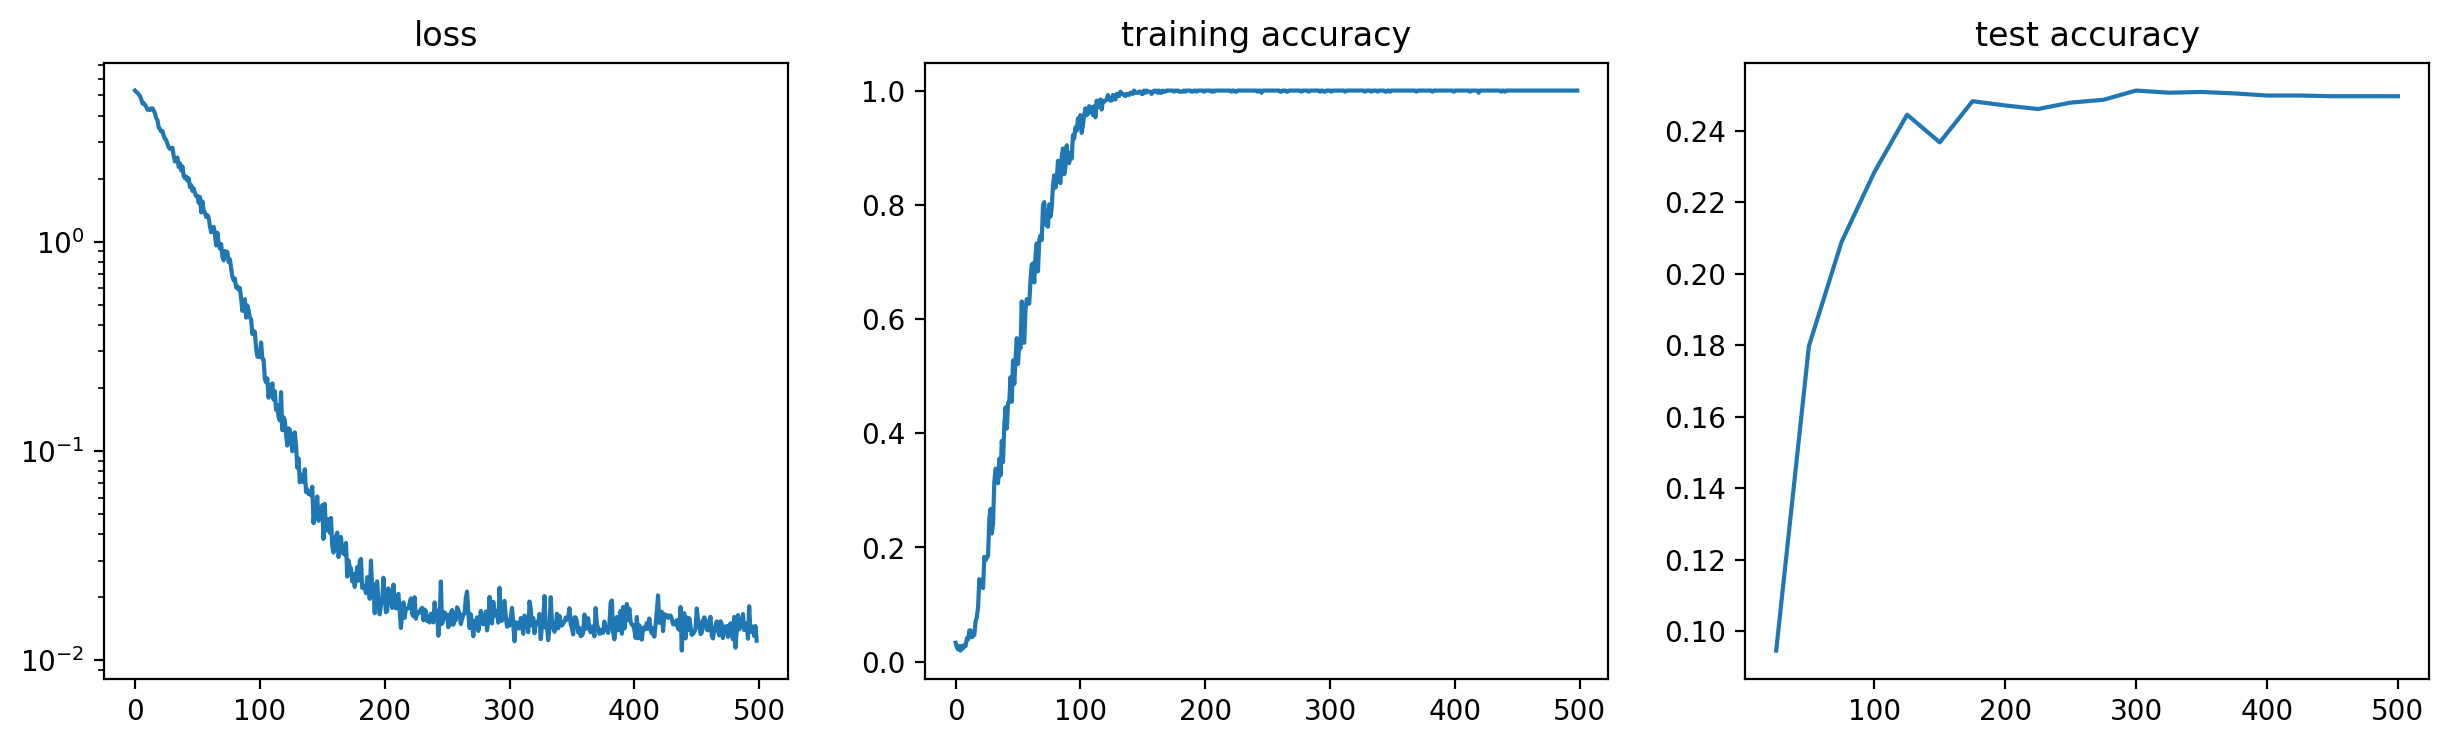

In [130]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.plot(losses[:-1])
ax1.set_yscale('log')
ax1.set_title('loss')
ax2.plot(accus_train[:-1])
ax2.set_title('training accuracy')
ax3.plot(np.arange(25, 501, 25), accus_test)
ax3.set_title('test accuracy');